# Uber Pickups - PART I

## Utiliser les KMeans pour des Trips Uber

Dans ce projet, vous allez vous rendre compte du pouvoir des KMeans dans le monde actuel. Imaginez que vous êtes Uber et que vous souhaitez donner des recommendations quant aux endroits où les chauffeurs devraient se trouver pour maximiser leurs chances de trouver une course.

Nous allons utiliser le Machine Learning pour créer cet algorithme de recommandations.

Prenez le dataset suivant : [uber-trip-data](https://github.com/fivethirtyeight/uber-tlc-foil-response/tree/master/uber-trip-data)

1. Essayez de voir le nombre de clusters optimum
2. Trouvez ces clusters sur une map
3. Séparez maintenant ces clusters en fonction des périodes de la journée
4. Regardez la différence KMeans et DBSCAN


In [ ]:
!pip install plotly==4.8.1
!jupyter labextension install jupyterlab-plotly@4.8.1

  Using cached plotly-4.8.1-py2.py3-none-any.whl (11.5 MB)
Processing /home/jovyan/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56/retrying-1.3.3-py3-none-any.whl
Building jupyterlab assets (build:prod:minimize)


In [1]:
!pip install yellowbrick

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)


In [3]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [4]:
all_dates = ["apr", "aug", "jul", "jun", "may", "sep"]

all_df = (pd.read_csv(f"https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-{date}14.csv", 
                       parse_dates=[0]) for date in all_dates)

df = pd.concat(all_df, ignore_index=True)

In [5]:
df.head()

,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


In [6]:
cal = calendar()
dr = df["Date/Time"]
df["hours"] = dr.dt.hour
df["day"] = dr.dt.day
df["dayofweek"] = dr.dt.dayofweek
df["dayname"] = dr.dt.day_name()
df["month"] = dr.dt.month
df["holidays"] = dr.dt.date.astype('datetime64').isin(cal.holidays(start=dr.min(), end=dr.max()))

base_map = {"B02512": "Unter", "B02598": "Hinter", "B02617": "Weiter", "B02682": "Schmecken", "B02764": "Danach-NY", 
            "B02765": "Grun", "B02835": "Dreist", "B02836": "Drinnen"}

df["Base"].replace(base_map, inplace=True)
df.head()

,Date/Time,Lat,Lon,Base,hours,day,dayofweek,dayname,month,holidays
0,2014-04-01 00:11:00,40.7690,-73.9549,Unter,0,1,1,Tuesday,4,False
1,2014-04-01 00:17:00,40.7267,-74.0345,Unter,0,1,1,Tuesday,4,False
2,2014-04-01 00:21:00,40.7316,-73.9873,Unter,0,1,1,Tuesday,4,False
3,2014-04-01 00:28:00,40.7588,-73.9776,Unter,0,1,1,Tuesday,4,False
4,2014-04-01 00:33:00,40.7594,-73.9722,Unter,0,1,1,Tuesday,4,False


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

def scale_data(df):
    df_scale = df[["Lat", "Lon"]].copy()

    df_scale = scale.fit_transform(df_scale)
    return df_scale

def plot_elbow(df_scale, ax=None):
    # Instantiate the clustering model and visualizer
    model = KMeans(random_state = 0)
    visualizer = KElbowVisualizer(model, k=(2,10), timings=False, ax=ax)

    visualizer.fit(df_scale)        # Fit the data to the visualizer
    visualizer.show()  
    
def clusterize_data(df):
    knn = KMeans(n_clusters= 5, random_state = 0)
    _, size_cluster = np.unique(knn.fit_predict(df), return_counts=True)
    df_coord_clusters = pd.DataFrame(scale.inverse_transform(knn.cluster_centers_), columns=["Lat", "Long"])
    df_coord_clusters["size"] = size_cluster
    df_coord_clusters["invert_rank"] = df_coord_clusters["size"].rank(method='max', ascending=True).astype(int)
    return df_coord_clusters

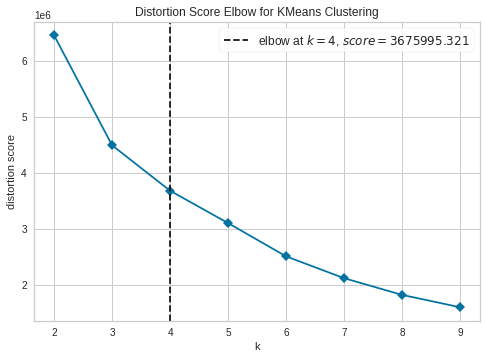

In [8]:
df_scale = scale_data(df)
plot_elbow(df_scale)

In [5]:
df_scale = scale_data(df)
df_coord_clusters = clusterize_data(df_scale)

df_coord_clusters

,Lat,Long,size,invert_rank
0,40.763812,-73.974781,1788615,4
1,40.665080,-73.766795,147921,1
2,40.678300,-73.967529,447085,3
3,40.727945,-73.999889,1908873,5
4,40.805496,-73.884717,241833,2


In [19]:
import plotly.express as px

fig = px.scatter_mapbox(df_coord_clusters, 
                        lat="Lat", 
                        lon="Long", 
                        zoom = 9, 
                        color = 'size', 
                        size = 'invert_rank',
                        color_continuous_scale = 'Bluered', 
                        mapbox_style="carto-positron")
fig.show()

In [9]:
non_holidays = df[df["holidays"] == False].groupby(["hours", "dayofweek", "dayname"]).count()[["Lat"]].copy().reset_index()
non_holidays.loc[non_holidays["dayofweek"] < 5, "type_day"] = "week days"
non_holidays.loc[non_holidays["dayofweek"] >= 5, "type_day"] = "week end"

holidays = df[df["holidays"]].groupby(["hours", "dayofweek", "dayname"]).count()[["Lat"]].copy().reset_index()
holidays["type_day"] = "holidays"
plot = pd.concat([non_holidays, holidays])
plot.rename({"Lat": "Nb uber rides"}, axis=1, inplace=True)

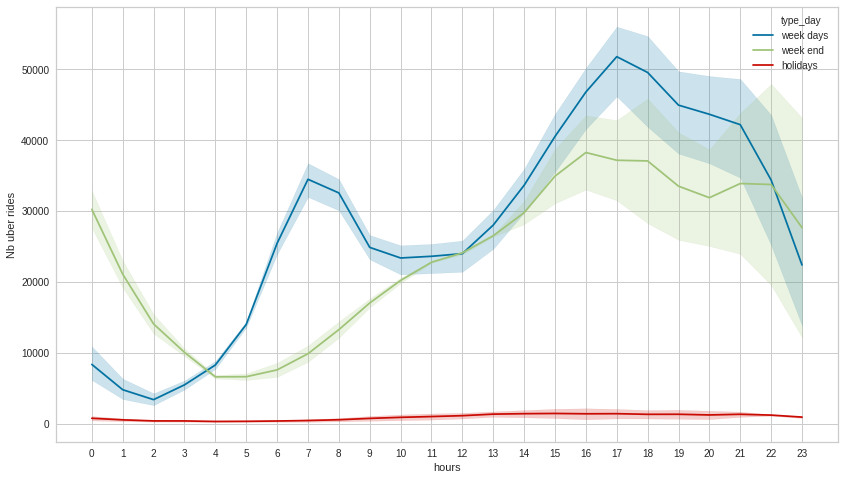

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))

graph = sns.lineplot(data=plot, x="hours", y="Nb uber rides", hue="type_day", markers=True)
graph.set_xticks(df["hours"].value_counts().index)

plt.show()

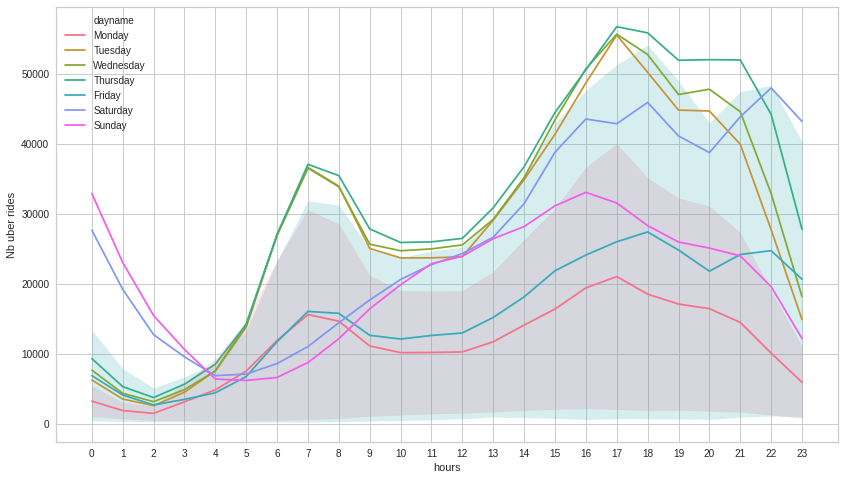

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

graph = sns.lineplot(data=plot, x="hours", y="Nb uber rides", hue="dayname", markers=True)
graph.set_xticks(df["hours"].value_counts().index)

plt.show()

In [10]:
week_days = df[(df["holidays"] == False) & (df["dayofweek"] < 5)]
week_end = df[(df["holidays"] == False) & (df["dayofweek"] >= 5)]

interval_week = {
    "Week day moring rush hour": (5, 10), 
    "Week day": (10, 15), 
    "Week day evening rush hour": (15, 21), 
    "Week day evening": (21, 5)
}

interval_weekend = {
    "Weekend morning": (3, 12), 
    "Weekend day": (12, 20), 
    "Weekend evening": (20, 3)
}

def interval_data(df, interval):
    left, right = interval
    if left < right:
        return df[(left <= df["hours"]) & (df["hours"] < right)][["Lat", "Lon"]]
    else:
        return df[(left < df["hours"]) | (df["hours"] <= right)][["Lat", "Lon"]]

df_holidays = [df[df["holidays"]][["Lat", "Lon"]]]
df_non_holidays = [interval_data(week_days, interval) for interval in interval_week.values()] 
df_non_holidays += [interval_data(week_end, interval) for interval in interval_weekend.values()]

In [11]:
list_subsets = [df_non_holidays, df_holidays]

scale = StandardScaler()

norm_subsets = [[scale.fit_transform(data) for data in list_subset] for list_subset in list_subsets]

In [17]:
list_values = list(interval_week.keys()) + list(interval_weekend.keys())
clusters_datas = [pd.concat([clusterize_data(data).assign(idx_hour=idx if not len(norm_subset) else list_values[idx]) 
for idx, data in enumerate(norm_subset)]) for norm_subset in norm_subsets]

In [20]:
titles = ["non holidays", "holidays"]
for idx, data in enumerate(clusters_datas):
    fig = px.scatter_mapbox(
            data, 
            lat="Lat", 
            lon="Long", 
            zoom = 9, 
            color = 'size', 
            size = 'invert_rank',
            color_continuous_scale = 'Bluered', 
            mapbox_style="carto-positron", 
            animation_frame = 'idx_hour',
            title = titles[idx])

    fig.show()